In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('fruit.csv')
df.head()

,Acidity,Firmness,Sweetness,Weight,Water_Content,Fruit_Name,Acid_Firm_Ratio,Sweet_Acid_Balance,Density_Index
0,3.74,3.14,6.94,173.40,84.92,Apple,1.19,3.20,2.02
1,4.37,2.79,6.10,165.28,88.98,Orange,1.57,1.73,1.84
2,4.09,2.80,6.74,183.04,74.89,Orange,1.46,2.65,2.41
3,4.60,2.76,6.57,192.92,71.71,Apple,1.67,1.97,2.65
4,1.87,4.64,7.84,185.15,72.72,Apple,0.40,5.97,2.51


In [3]:
print("Missing values per kolom:")
missing_per_col = df.isnull().sum()
print(missing_per_col[missing_per_col > 0])

df_clean = df.copy()

for col in ['Acidity', 'Firmness', 'Sweetness', 'Weight', 'Water_Content']:
    apple_mean = df_clean[df_clean['Fruit_Name'] == 'Apple'][col].mean()
    orange_mean = df_clean[df_clean['Fruit_Name'] == 'Orange'][col].mean()
    df_clean.loc[(df_clean['Fruit_Name'] == 'Apple') & (df_clean[col].isnull()), col] = apple_mean
    df_clean.loc[(df_clean['Fruit_Name'] == 'Orange') & (df_clean[col].isnull()), col] = orange_mean

for col in ['Acid_Firm_Ratio', 'Sweet_Acid_Balance', 'Density_Index']:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print(f"Setelah handling: {df_clean.isnull().sum().sum()} missing values")

Missing values per kolom:
Acidity                9
Firmness               9
Sweetness              8
Weight                 7
Water_Content          7
Acid_Firm_Ratio       22
Sweet_Acid_Balance    22
Density_Index         14
dtype: int64
Setelah handling: 0 missing values


In [4]:
print(f"Duplikat: {df_clean.duplicated().sum()}")

df_clean = df_clean.drop_duplicates()
print(f"Setelah handling: {df_clean.duplicated().sum()} duplikat")

Duplikat: 20
Setelah handling: 0 duplikat


In [5]:
def cek_outliers(df, kolom):
    Q1 = df[kolom].quantile(0.25)
    Q3 = df[kolom].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[kolom] < lower_bound) | (df[kolom] > upper_bound)]
    return len(outliers)

print("Outliers sebelum handling:")
for col in ['Acidity', 'Firmness', 'Sweetness', 'Weight', 'Water_Content']:
    outliers = cek_outliers(df_clean, col)
    print(f"  {col}: {outliers} outliers")

def handle_outliers(df, columns):
    df_out = df.copy()
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_out[col] = np.where(df_out[col] < lower_bound, lower_bound, df_out[col])
        df_out[col] = np.where(df_out[col] > upper_bound, upper_bound, df_out[col])
    return df_out

df_clean = handle_outliers(df_clean, ['Acidity', 'Firmness', 'Sweetness', 'Weight', 'Water_Content'])

Outliers sebelum handling:
  Acidity: 8 outliers
  Firmness: 10 outliers
  Sweetness: 12 outliers
  Weight: 7 outliers
  Water_Content: 17 outliers


In [6]:
print("Distribusi sebelum balancing:")
print(df_clean['Fruit_Name'].value_counts())

apple_data = df_clean[df_clean['Fruit_Name'] == 'Apple']
orange_data = df_clean[df_clean['Fruit_Name'] == 'Orange']

if len(orange_data) < len(apple_data):
    orange_oversampled = orange_data.sample(n=len(apple_data), replace=True, random_state=42)
    df_balanced = pd.concat([apple_data, orange_oversampled])
else:
    df_balanced = df_clean.copy()

print("Distribusi setelah balancing:")
print(df_balanced['Fruit_Name'].value_counts())

Distribusi sebelum balancing:
Fruit_Name
Apple     714
Orange    486
Name: count, dtype: int64
Distribusi setelah balancing:
Fruit_Name
Apple     714
Orange    714
Name: count, dtype: int64


In [7]:
target_map = {'Apple': 0, 'Orange': 1}
target_encoded = df_balanced['Fruit_Name'].map(target_map)

correlations = {}
numeric_cols = ['Acidity', 'Firmness', 'Sweetness', 'Weight', 'Water_Content', 
                'Acid_Firm_Ratio', 'Sweet_Acid_Balance', 'Density_Index']

for col in numeric_cols:
    correlation = np.corrcoef(df_balanced[col], target_encoded)[0,1]
    correlations[col] = abs(correlation)

print("Korelasi fitur dengan target:")
for feature, corr in sorted(correlations.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feature}: {corr:.4f}")

selected_features = [feat for feat, corr in correlations.items() if corr > 0.1]
print(f"\nSelected features: {selected_features}")

Korelasi fitur dengan target:
  Density_Index: 0.5910
  Firmness: 0.5538
  Acidity: 0.5139
  Weight: 0.5091
  Acid_Firm_Ratio: 0.4337
  Water_Content: 0.4046
  Sweetness: 0.3982
  Sweet_Acid_Balance: 0.0199

Selected features: ['Acidity', 'Firmness', 'Sweetness', 'Weight', 'Water_Content', 'Acid_Firm_Ratio', 'Density_Index']


In [ ]:
class ManualKNN:
    def __init__(self, k=3, metric='euclidean'):
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None
    
    def euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def manhattan_distance(self, point1, point2):
        return np.sum(np.abs(point1 - point2))
    
    def minkowski_distance(self, point1, point2, p=3):
        return np.sum(np.abs(point1 - point2) ** p) ** (1/p)
    
    def calculate_distance(self, point1, point2):
        if self.metric == 'euclidean':
            return self.euclidean_distance(point1, point2)
        elif self.metric == 'manhattan':
            return self.manhattan_distance(point1, point2)
        elif self.metric == 'minkowski':
            return self.minkowski_distance(point1, point2)
    
    def fit(self, X, y):
        self.X_train = X.values if isinstance(X, pd.DataFrame) else X
        self.y_train = y.values if isinstance(y, pd.Series) else y
        
    def predict(self, X):
        X_test = X.values if isinstance(X, pd.DataFrame) else X
        predictions = []
        
        for test_point in X_test:
            distances = []
            for i, train_point in enumerate(self.X_train): # type: ignore
                dist = self.calculate_distance(test_point, train_point)
                distances.append((dist, self.y_train[i])) # type: ignore
            
            distances.sort(key=lambda x: x[0])
            k_nearest = [label for _, label in distances[:self.k]]
            predictions.append(max(set(k_nearest), key=k_nearest.count))
            
        return np.array(predictions)


In [ ]:
X = df_balanced[selected_features]
y = df_balanced['Fruit_Name'].map({'Apple': 0, 'Orange': 1})

np.random.seed(42)
indices = np.random.permutation(len(X))
test_size = int(0.2 * len(X))
test_indices = indices[:test_size]
train_indices = indices[test_size:]

X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

In [ ]:
def manual_scaler(X_train, X_test):
    mean = X_train.mean()
    std = X_train.std()
    return (X_train - mean) / std, (X_test - mean) / std

X_train_scaled, X_test_scaled = manual_scaler(X_train, X_test)

In [12]:
k_values = [3, 5, 7, 9, 11]
metrics = ['euclidean', 'manhattan', 'minkowski']

results = []

print("K\tMetric\t\tAccuracy")
print("-" * 30)

for k in k_values:
    for metric in metrics:
        knn = ManualKNN(k=k, metric=metric)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        
        accuracy = np.sum(y_pred == y_test.values) / len(y_test)
        results.append({'k': k, 'metric': metric, 'accuracy': accuracy})
        
        print(f"{k}\t{metric:12}\t{accuracy:.4f}")

best_result = max(results, key=lambda x: x['accuracy'])
print(f"\nBest: k={best_result['k']}, metric={best_result['metric']}, accuracy={best_result['accuracy']:.4f}")

K	Metric		Accuracy
------------------------------
3	euclidean   	0.9053
3	manhattan   	0.9018
3	minkowski   	0.9158
5	euclidean   	0.8737
5	manhattan   	0.8702
5	minkowski   	0.8632
7	euclidean   	0.8772
7	manhattan   	0.8667
7	minkowski   	0.8596
9	euclidean   	0.8667
9	manhattan   	0.8807
9	minkowski   	0.8807
11	euclidean   	0.8737
11	manhattan   	0.8807
11	minkowski   	0.8842

Best: k=3, metric=minkowski, accuracy=0.9158


In [13]:
# Fungsi evaluasi manual
def evaluation_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) != 0 else 0
    
    return accuracy, precision, recall, f1


In [ ]:
results = []

print(f"{'K':<3}{'Metric':<12}{'Acc':<10}{'Prec':<10}{'Rec':<10}{'F1':<10}")
print("-" * 60)

for k in k_values:
    for metric in metrics:
        knn = ManualKNN(k=k, metric=metric)
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)

        acc, prec, rec, f1 = evaluation_metrics(y_test.values, y_pred)
        
        results.append({
            'k': k,
            'metric': metric,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })

        print(f"{k:<3}{metric:<12}{acc:.4f}\t{prec:.4f}\t{rec:.4f}\t{f1:.4f}")

best_result = max(results, key=lambda x: x['f1'])

print("\n Best Model Based on F1-Score:")
print(f"K = {best_result['k']}, Metric = {best_result['metric']}")
print(f"Accuracy = {best_result['accuracy']:.4f}")
print(f"Precision = {best_result['precision']:.4f}")
print(f"Recall = {best_result['recall']:.4f}")
print(f"F1-Score = {best_result['f1']:.4f}")


K  Metric      Acc       Prec      Rec       F1        
------------------------------------------------------------
3  euclidean   0.9053	0.8861	0.9396	0.9121
3  manhattan   0.9018	0.8854	0.9329	0.9085
3  minkowski   0.9158	0.9032	0.9396	0.9211
5  euclidean   0.8737	0.8742	0.8859	0.8800
5  manhattan   0.8702	0.8590	0.8993	0.8787
5  minkowski   0.8632	0.8716	0.8658	0.8687
7  euclidean   0.8772	0.8608	0.9128	0.8860
7  manhattan   0.8667	0.8535	0.8993	0.8758
7  minkowski   0.8596	0.8428	0.8993	0.8701
9  euclidean   0.8667	0.8581	0.8926	0.8750
9  manhattan   0.8807	0.8662	0.9128	0.8889
9  minkowski   0.8807	0.8616	0.9195	0.8896
11 euclidean   0.8737	0.8693	0.8926	0.8808
11 manhattan   0.8807	0.8662	0.9128	0.8889
11 minkowski   0.8842	0.8718	0.9128	0.8918

 Best Model Based on F1-Score:
K = 3, Metric = minkowski
Accuracy = 0.9158
Precision = 0.9032
Recall = 0.9396
F1-Score = 0.9211


In [ ]:
TP = np.sum((y_test.values == 1) & (y_pred == 1))
TN = np.sum((y_test.values == 0) & (y_pred == 0))
FP = np.sum((y_test.values == 0) & (y_pred == 1))
FN = np.sum((y_test.values == 1) & (y_pred == 0))

conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[116  20]
 [ 13 136]]


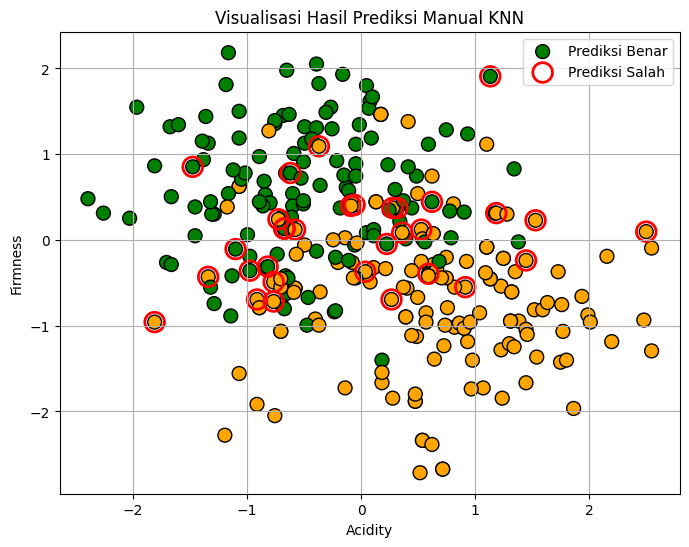

In [16]:
x_axis = X_test_scaled.iloc[:, 0]
y_axis = X_test_scaled.iloc[:, 1]

colors = ['green' if p == 0 else 'orange' for p in y_pred]

plt.figure(figsize=(8, 6))
plt.scatter(x_axis, y_axis, c=colors, edgecolor='black', s=100)

for i in range(len(y_test)):
    if y_pred[i] != y_test.values[i]:
        plt.scatter(x_axis.iloc[i], y_axis.iloc[i], 
                    facecolors='none', edgecolors='red', s=200, linewidth=2)

plt.title("Visualisasi Hasil Prediksi Manual KNN")
plt.xlabel(X_test_scaled.columns[0])
plt.ylabel(X_test_scaled.columns[1])
plt.grid(True)
plt.legend(["Prediksi Benar", "Prediksi Salah"], loc='best')
plt.show()